# Reinforcement Learning: stochastic upwind/downwind turning model

![](data/intermittent_smoke_med.gif)
<br>
This repository explores the use of traditional Reinforcement Learning *temporal-difference* methods such as the <a href=https://en.wikipedia.org/wiki/Q-learning> Q-learning </a> algorithm to understand how agents can learn to navigate to the source of a 2D turbulent odor plume. Turbulent odor plumes are spatiotemporally complex: odor signals arrive in random, unpredictable bursts, and odor concentration does follow continuous gradients, making plume navigation a difficult task. Surprisingly, there has been no published work on applying RL algorithms to turbulent odor plume navigation. This notebook will explore a simple model of navigation with a reduced set of states.

Results teaser:

<img src="data/trajectories.gif"  /><img src="data/Q_plots.gif" />

<br>
<br>




## Q-learning algorithm
Q-learning updates a state-action value function, $Q(a, s)$, which quantifies the value of taking action $a$ when in state $s$. This function is updated in time using the Q-learning algorithm. At each timestep, the navigator takes an action $A$ to go from state $S$ to state $S'$, using whatever policy (greedy, $\epsilon$-greedy, etc.), where it receives a reward $R$. Then $Q(A, S)$ is updated using a *greedy* update rule (hence *off-policy*):

$\begin{align}
 Q(A, S) \leftarrow Q(A, S) + \alpha[R + \gamma \max_a Q(a, S')  - Q(A, S)]
\end{align}$

Here, $\alpha < 1$ and $\gamma < 1$ are learning and reward discount rate -- both hyperparameters in the simulation.

## Model states, actions, and rewards

The *upwind-downwind-centerline* model explored in this notebook is defined by its states and actions.

### State space: $\{s\}$

Following results found recently for navigation of odor plumes by fruit flies, we assume that navigators rely on the frequency of odor hits. An odor hit is the time at which the signal surpassses a given threshold. Running average of hit frequency, $W_{freq}$, is found by convolving the binary time series of odor hit times $w(t)$ with an exponential kernel ($\tau = 2$ seconds):

$W_{freq} = \int^t_{-\infty} e^{-(t-t')/\tau} w(t')dt'$

We discretize the state space by odor hit frequency with partitions $\{a_i\}$.

$S_i$: $a_i < W_{freq} < a_{i+1}$

### Action space: $\{a\}$
We assume that there are 2 actions:

$A_1$: Make a turn **upwind** with random angle $\sim \mathcal N(30, 10)$, following recent results in fruit fly navigation

$A_2$: Make a turn **downwind** with random angle $\sim \mathcal N(30, 10)$.

At each timestep, the actions are stochastic in the sense that there is a $p_{turn} < 1$ probability to turn, and a $1 - p_{turn}$ probability to make a small jitter, which is a turn with angle much less than 30 in a random direction.

### Reward space: $\{r\}$
We assume the rewards are 1 if the navigator is experiencing a plume hit (odor signal is above threshold) and 0 otherwise. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append('src')
from utils import gen_plot
from models import *

## Run the RL simulation

### Instantiate model class
Define number of parallel agents and how many steps in episode

In [2]:
a = stochastic_turning()
a.x0_min = 1000
a.num_walkers = 1000
a.def_actions()
a.num_steps = 5000

### Set the frequency partitions defining the states

In [3]:
freq_bins = [-1, 0.01, 0.5, 1, 2, 3, 100]
a.def_states(freq_bins=freq_bins)

### Run

In [4]:
xs, ys, Q, Q_terminal, path_lengths = a.run()

100.0%

### Plot the Q-function for each state

Note that as odor hit frequency increases, the optimal action goes from being random to being more directed upwind.

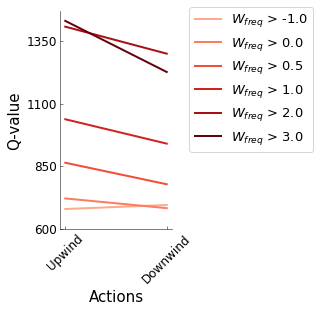

In [11]:
fig, ax = gen_plot(2, 4)
colors = plt.cm.Reds(np.linspace(0.3, 1.0, a._num_states))
for iS in range(a._num_states):
    plt.plot(Q_terminal[iS], color=colors[iS], lw=2, 
            label='$W_{freq}$ > %.1f' % freq_bins[iS])

plt.xlabel('Actions', fontsize=15)
plt.ylabel('Q-value', fontsize=15)
plt.xticks(range(a._num_actions), fontsize=12)
plt.yticks(np.arange(600, 1600, 250), fontsize=12)
ax.set_xticklabels(['Upwind', 'Downwind'], rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=13)
plt.show()

### Plot trajectories of virtual navigators during learning
Blue is beginning; yellow is end. Odor source is at middle left (see plume snapshot above)

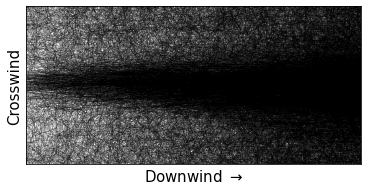

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
for iW in range(a.num_walkers):
    plt.plot(xs[:path_lengths[iW], iW], 
                ys[:path_lengths[iW], iW], color='k',
                lw=0.1)

ax.set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Downwind $\rightarrow$', fontsize=15)
plt.ylabel('Crosswind', fontsize=15)
ax.set_xlim(150, 1000)
ax.set_ylim(450 - 200, 450 + 200)
plt.show()

### Plot the softmax action selection of Q-function with temperature $T = 125$
Softmax derives a probability of each action from the learned $Q$, as such:

\begin{align}
p_{T}(action|state) = \frac{e^{Q(action|states)/T}}{\sum_{actions}e^{Q(action|states)/T}}
\end{align}

Note that as odor hit frequency increases, the optimal action goes from being slightly downwind-preferred to being strongly upwind.

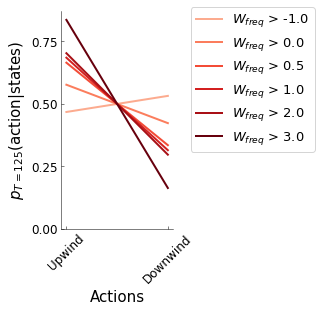

In [14]:
temp = 125
Q_norm = (np.exp(Q_terminal.T/temp)/np.sum(np.exp(Q_terminal/temp), axis=-1)).T

fig, ax = gen_plot(2, 4)
colors = plt.cm.Reds(np.linspace(0.3, 1.0, a._num_states))
for iS in range(a._num_states):
    avg_freq = max((freq_bins[iS] + freq_bins[iS + 1])/2, 0)
    plt.plot(Q_norm[iS], color=colors[iS], lw=2, 
             label='$W_{freq}$ > %.1f' % freq_bins[iS])

plt.xlabel('Actions', fontsize=15)
plt.ylabel(r'$p_{T=%s}($action|states)' % temp, fontsize=15)
plt.xticks(range(a._num_actions), fontsize=12)
plt.yticks([0, 0.25, 0.5, 0.75], fontsize=12)
ax.set_xticklabels(['Upwind', 'Downwind'], rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=13)
plt.show()

### Simulate navigators using learned softmax Q-policy

Navigators choose actions that optimize $p_T(actions|state)$, derived from the softmax of $Q$. This policy is $\epsilon$-greedy, whereby random actions are chosen with probability $\epsilon = 5\%$

In [129]:
a.x0_min = 500
a.xo_max = 1000
a.max_x = 1000
a.y0_spread = 200
xs, ys, path_lengths = a.run_optimal_action(Q_terminal, temp=125)

99.9%

### Plot the navigator trajectories from softmax Q-policy
Note that optimal policy outside of the plume (odor hit frequency is low) is to take random actions with some preference for moving toward the centerline. Once in a region of high hits, the optimal policy is to go upwind, so the navigators move toward the source once in the center of the plume

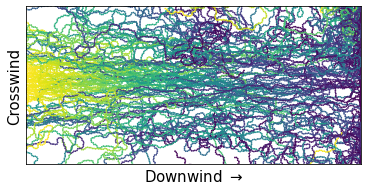

In [131]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 4)
for iW in range(a.num_walkers):
    colors = plt.cm.viridis(np.linspace(0, 1, path_lengths[iW]))
    plt.scatter(xs[:path_lengths[iW], iW], 
                ys[:path_lengths[iW], iW], 
                c=colors, s=.5)

ax.set_aspect('equal')
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Downwind $\rightarrow$', fontsize=15)
plt.ylabel('Crosswind', fontsize=15)
ax.set_xlim(150, 1000)
ax.set_ylim(450 - 200, 450 + 200)
plt.show()

## Run RL with only 3 states: low, medium, and high frequency

In [15]:
a = stochastic_turning()
a.x0_min = 500
a.xo_max = 1000
a.max_x = 1000
a.y0_spread = 200
a.num_walkers = 1000
a.num_steps = 5000
a.def_actions()

In [16]:
freq_bins = [-1, 0.5, 2, 100]
a.def_states(freq_bins=freq_bins)
xs, ys, Q, Q_terminal, path_lengths = a.run()

100.0%

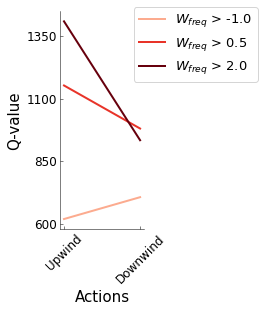

In [21]:
fig, ax = gen_plot(1.5, 4)
colors = plt.cm.Reds(np.linspace(0.3, 1.0, a._num_states))
for iS in range(a._num_states):
    plt.plot(Q_terminal[iS], color=colors[iS], lw=2,
            label='$W_{freq}$ > %.1f' % freq_bins[iS])

plt.xlabel('Actions', fontsize=15)
plt.ylabel('Q-value', fontsize=15)
plt.xticks(range(a._num_actions), fontsize=12)
plt.yticks(np.arange(600, 1600, 250), fontsize=12)
ax.set_xticklabels(['Upwind', 'Downwind'], rotation=45)
plt.legend(bbox_to_anchor=(0.8, 1.05), fontsize=13)
plt.show()

## Plot progression of Q-function during learning
Will plot how these change in time also as a **video** to include on the README.md as an illustrative example

In [23]:
# How many steps to plot before reaching the source
steps_to_src = 400

Q_snippet = np.empty((steps_to_src, a._num_states, 
                      a._num_actions, a.num_walkers))*np.nan
for iW in range(a.num_walkers):
    
    # If not long enough, just ignore; otherwise append last steps_to_src points
    if path_lengths[iW] < steps_to_src:
        Q_snippet[:, :, :, iW] = np.nan
    else:
        Q_snippet[:, :, :, iW] = Q[path_lengths[iW] - steps_to_src:path_lengths[iW], :, :, iW]

Q_avg = np.nanmean(Q_snippet, axis=-1)

Plot the Q-function during learning for each state. Note that high frequency has a higher probability of upwind turning

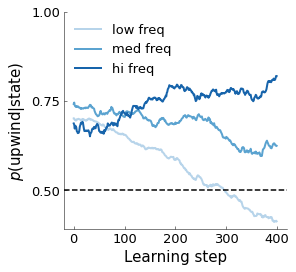

In [27]:
temp = 0.3
fig = gen_plot(4, 4)
Qs_to_plot = []
labels = ['low freq', 'med freq', 'hi freq']
for idx in range(a._num_states):
    Q1 = np.exp(Q_avg[:, idx, 0]/temp)
    Q2 = np.exp(Q_avg[:, idx, 1]/temp)
    Q1_normed = Q1/(Q1 + Q2)
    Qs_to_plot.append(Q1_normed)
    plt.plot(Q1_normed, color=plt.cm.Blues(idx/(a._num_states + 1) + 0.3), 
             lw=2, label=labels[idx])
plt.axhline(0.5, color='k', ls='--')
plt.yticks(np.arange(0.5, 1.01, 0.25), fontsize=13)
plt.ylabel('$p$(upwind|state)', fontsize=15)
plt.xticks(np.arange(0, steps_to_src + 1, 100), fontsize=13)
plt.xlabel('Learning step', fontsize=15)
plt.legend(loc=2, frameon=False, fontsize=13)
plt.show()

Plot a video of the above plot for the README.md file

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(20, 10)
video = None
for frm in range(steps_to_src):
    print (frm, end=" ", flush=True)

    # Plot regularly in matplotlib first
    plt.plot(range(steps_to_src)[:frm], Qs_to_plot[0][:frm], 
             color=plt.cm.Reds(0.3), lw=10)
    plt.plot(range(steps_to_src)[:frm], Qs_to_plot[1][:frm], 
             color=plt.cm.Reds(0.6), lw=10)
    plt.plot(range(steps_to_src)[:frm], Qs_to_plot[2][:frm], 
             color=plt.cm.Reds(0.9), lw=10)
    fig.canvas.draw()

    # Save to pixelated array
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Opencv video container must have same shape as data 
    if video is None:
        fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
        video = cv2.VideoWriter('data/Q_plots.avi', fourcc, 60, 
                                (data.shape[1], data.shape[0]))
        plt.xlim(0, steps_to_src)
        plt.ylim(0.4, 0.9)
        plt.xticks([])
        plt.yticks(np.arange(0.4, 1, 0.1), fontsize=45)
        plt.ylabel('p(upwind|state)', fontsize=60, labelpad=25)
        plt.axhline(0.5, color='k', ls='--')
        ax.spines['left'].set_linewidth(5)
        for axis in ['right','top', 'bottom']:
              ax.spines[axis].set_linewidth(0)
    
    # Video image contains all plots up to this frame
    video.write(data)

video.release()

Repeat for trajectories

In [31]:
xs_plot = np.empty((steps_to_src, a.num_walkers))*np.nan
ys_plot = np.empty((steps_to_src, a.num_walkers))*np.nan
for iW in range(a.num_walkers):
    if path_lengths[iW] < steps_to_src:
        xs_plot[:, iW] = np.nan
        ys_plot[:, iW] = np.nan
    else:
        xs_plot[:, iW] = xs[path_lengths[iW] - steps_to_src:path_lengths[iW], iW]
        ys_plot[:, iW] = ys[path_lengths[iW] - steps_to_src:path_lengths[iW], iW]

In [ ]:
plot_every = 10

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches(20, 10)
video = None
for frm in range(400):
    print (frm, end=" ", flush=True)

    # Plot regularly in matplotlib first
    plt.plot(xs_plot[:frm, ::plot_every], ys_plot[:frm, ::plot_every], 
             color='k', lw=2)
    fig.canvas.draw()

    # Save to pixelated array
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    # Opencv video container must have same shape as data 
    if video is None:
        fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
        video = cv2.VideoWriter('data/trajectories.avi', fourcc, 60, 
                                (data.shape[1], data.shape[0]))
        plt.xlim(150, 1000)
        plt.ylim(450 - 200, 450 + 200)
        plt.xticks([])
        plt.yticks([])
        for axis in ['right','top', 'bottom', 'left']:
              ax.spines[axis].set_linewidth(5)
    
    # Video image contains all trajectories up to this frame
    video.write(data)

video.release()